Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [5]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [8]:
train_wards = pd.read_csv("/home/alex/data/tanzania-pumps-rasterstats/train_wards.csv")
test_wards = pd.read_csv("/home/alex/data/tanzania-pumps-rasterstats/test_wards.csv")

train_elev = pd.read_csv("/home/alex/data/tanzania-pumps-rasterstats/train_srtm_elevation.csv")
test_elev = pd.read_csv("/home/alex/data/tanzania-pumps-rasterstats/test_srtm_elevation.csv")

In [10]:
train_merged = train.merge(train_wards, on="id").merge(train_elev, on="id")
test_merged = test.merge(test_wards, on="id").merge(test_elev, on="id")

In [12]:
train_merged.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude_x', 'latitude_x', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group', 'Unnamed: 0_x', 'Region_Cod',
       'Region_Nam', 'District_C', 'District_N', 'Ward_Code', 'Ward_Name',
       'Division', 'Unnamed: 0_y', 'latitude_y', 'longitude_y', 'elevation'],
      dtype='object')

In [20]:
def clean_columns(df):
    dataframe = df.copy()
    dataframe.rename(columns={"longitude_x":"longitude","latitude_x":"latitude"}, inplace=True)
    dataframe.drop(["Unnamed: 0_x","Unnamed: 0_y","latitude_y","longitude_y","gps_height"], axis=1, inplace=True)
    return dataframe
    
    

In [22]:
train_clean = clean_columns(train_merged)
test_clean = clean_columns(test_merged)

In [24]:
from sklearn.model_selection import train_test_split


In [25]:
train_clean, validate_clean = train_test_split(
    train_clean, 
    train_size=0.80, 
    test_size=0.20, 
    stratify=train['status_group'], 
    random_state=42)

In [26]:
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    
    # return the wrangled dataframe
    return X

In [29]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train_clean.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features
categorical_features = cardinality.index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [31]:
def reduce_cardinality_to_top_ten(feature, train, validate, test):
    
    # Get a list of the top 10 entries in feature of interest
    top10 = train[feature].value_counts()[:10].index
    
    train = train.copy()
    validate = validate.copy()
    test = test.copy()
    
    # At locations where the feature entry is NOT in the top 10,
    # replace the entry with 'OTHER'
    train.loc[~train[feature].isin(top10), feature] = 'OTHER'
    validate.loc[~validate[feature].isin(top10), feature] = 'OTHER'
    test.loc[~test[feature].isin(top10), feature] = 'OTHER'
    
    return train, validate, test

In [33]:
categorical_features_with_more_than_ten_categories = []
for feature in categorical_features:
    if len(train_clean[feature].unique()) > 10:
           categorical_features_with_more_than_ten_categories.append(feature)
            
categorical_features_with_more_than_ten_categories

['date_recorded',
 'funder',
 'installer',
 'wpt_name',
 'subvillage',
 'region',
 'lga',
 'ward',
 'scheme_management',
 'scheme_name',
 'extraction_type',
 'extraction_type_group',
 'management',
 'Region_Nam',
 'District_N',
 'Ward_Name',
 'Division']

In [35]:
for feature in categorical_features_with_more_than_ten_categories:
    train_clean, validate_clean, test_clean = reduce_cardinality_to_top_ten(feature, train_clean, validate_clean, test_clean)

In [36]:
X_train = train_clean[features]
X_validate = validate_clean[features]
X_test = test_clean[features]

y_train = train_clean[target]
y_validate = validate_clean[target]

In [37]:
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


In [39]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=8, max_depth=32, max_features= 0.668819157886731, min_samples_leaf=2, n_estimators=370, n_jobs=-1))
    
pipeline.fit(X_train, y_train)

print(pipeline.score(X_train, y_train))
print(pipeline.score(X_validate, y_validate))

0.9709595959595959
0.8085016835016835


In [41]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=8, min_samples_leaf=2, n_jobs=-1, n_estimators=370))
    
pipeline.fit(X_train, y_train)

print(pipeline.score(X_train, y_train))
print(pipeline.score(X_validate, y_validate))

0.931523569023569
0.813973063973064


In [56]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=8, min_samples_leaf=2, n_jobs=-1, n_estimators=370, max_depth=32)
)
    
pipeline.fit(X_train, y_train)

print(pipeline.score(X_train, y_train))
print(pipeline.score(X_validate, y_validate))

0.9308712121212122
0.8146464646464646


In [57]:
y_pred = pipeline.predict(X_test)
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14353,39307,non functional
14354,18990,functional
14355,28749,functional
14356,33492,functional


In [58]:
submission.to_csv('/home/alex/code/DS-Unit-2-Kaggle-Challenge/module4-classification-metrics/alex-pakalniskis-kaggle-submission-day-4.1.csv', index=False)


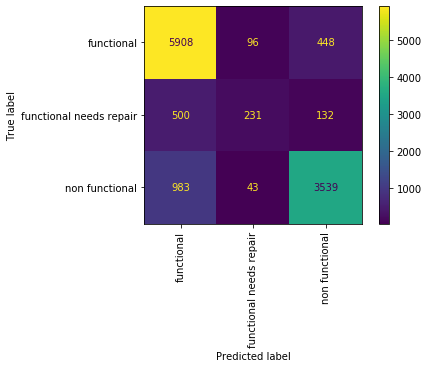

In [59]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipeline, X_validate, y_validate, values_format='.0f', xticks_rotation="vertical")

plt.show()

In [61]:
from sklearn.metrics import classification_report
y_pred = pipeline.predict(X_validate)
print(classification_report(y_validate, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.92      0.85      6452
functional needs repair       0.62      0.27      0.37       863
         non functional       0.86      0.78      0.82      4565

               accuracy                           0.81     11880
              macro avg       0.76      0.65      0.68     11880
           weighted avg       0.81      0.81      0.80     11880

